# Monetary Transmission Mechanism

## Introduction
[FRED-MD data](https://research.stlouisfed.org/econ/mccracken/fred-databases/)  
[FRED-MD Paper & Columns](https://s3.amazonaws.com/real.stlouisfed.org/wp/2015/2015-012.pdf)

In [1]:
# data
import pandas as pd
import pandas_profiling
import numpy as np
import datetime as dt

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.api import VAR, VARMAX

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas_datareader.data as web
import yfinance as yf

In [2]:
data = pd.read_csv('current.csv', index_col=0)
data = data.iloc[1:,:]
print(list(data.columns))

['RPI', 'W875RX1', 'DPCERA3M086SBEA', 'CMRMTSPLx', 'RETAILx', 'INDPRO', 'IPFPNSS', 'IPFINAL', 'IPCONGD', 'IPDCONGD', 'IPNCONGD', 'IPBUSEQ', 'IPMAT', 'IPDMAT', 'IPNMAT', 'IPMANSICS', 'IPB51222S', 'IPFUELS', 'CUMFNS', 'HWI', 'HWIURATIO', 'CLF16OV', 'CE16OV', 'UNRATE', 'UEMPMEAN', 'UEMPLT5', 'UEMP5TO14', 'UEMP15OV', 'UEMP15T26', 'UEMP27OV', 'CLAIMSx', 'PAYEMS', 'USGOOD', 'CES1021000001', 'USCONS', 'MANEMP', 'DMANEMP', 'NDMANEMP', 'SRVPRD', 'USTPU', 'USWTRADE', 'USTRADE', 'USFIRE', 'USGOVT', 'CES0600000007', 'AWOTMAN', 'AWHMAN', 'HOUST', 'HOUSTNE', 'HOUSTMW', 'HOUSTS', 'HOUSTW', 'PERMIT', 'PERMITNE', 'PERMITMW', 'PERMITS', 'PERMITW', 'ACOGNO', 'AMDMNOx', 'ANDENOx', 'AMDMUOx', 'BUSINVx', 'ISRATIOx', 'M1SL', 'M2SL', 'M2REAL', 'BOGMBASE', 'TOTRESNS', 'NONBORRES', 'BUSLOANS', 'REALLN', 'NONREVSL', 'CONSPI', 'S&P 500', 'S&P: indust', 'S&P div yield', 'S&P PE ratio', 'FEDFUNDS', 'CP3Mx', 'TB3MS', 'TB6MS', 'GS1', 'GS5', 'GS10', 'AAA', 'BAA', 'COMPAPFFx', 'TB3SMFFM', 'TB6SMFFM', 'T1YFFM', 'T5YFFM'

In [3]:
# check for missing values
print(data.isnull().sum().sort_values(ascending=False))
data = data.iloc[:-1,:]

ACOGNO           399
TWEXAFEGSMTHx    169
UMCSENTx         155
ANDENOx          110
VIXCLSx           43
                ... 
NDMANEMP           1
DMANEMP            1
MANEMP             1
USCONS             1
M1SL               1
Length: 127, dtype: int64


In [4]:
# ffill null values and drop column with the most null values
data = data.fillna(method='ffill')
to_drop = data.columns[data.isnull().sum() != 0].sort_values(ascending=False)
print(to_drop)

Index(['VIXCLSx', 'UMCSENTx', 'TWEXAFEGSMTHx', 'PERMITW', 'PERMITS',
       'PERMITNE', 'PERMITMW', 'PERMIT', 'ANDENOx', 'ACOGNO'],
      dtype='object')


In [5]:
# drop columns in to_drop
data = data.drop(to_drop, axis=1)
data.head()

RPI  W875RX1  DPCERA3M086SBEA    CMRMTSPLx      RETAILx  \
sasdate                                                                  
1/1/1959  2442.158   2293.2           17.272  292266.4261  18235.77392   
2/1/1959  2451.778   2301.5           17.452  294424.7425  18369.56308   
3/1/1959  2467.594   2318.5           17.617  293418.6704  18523.05762   
4/1/1959  2483.671   2334.9           17.553  299322.8039  18534.46600   
5/1/1959  2498.026   2350.4           17.765  301364.3249  18679.66354   

           INDPRO  IPFPNSS  IPFINAL  IPCONGD  IPDCONGD  ...   PCEPI  \
sasdate                                                 ...           
1/1/1959  22.0733  23.4027  22.2858  31.5688   18.6601  ...  16.042   
2/1/1959  22.5056  23.7185  22.4788  31.8004   18.7580  ...  16.057   
3/1/1959  22.8298  23.8621  22.5892  31.8004   19.1254  ...  16.068   
4/1/1959  23.3161  24.2067  22.9201  32.3021   19.2478  ...  16.100   
5/1/1959  23.6673  24.4077  23.1408  32.4565   19.6396  ...  16.109   

          DDURRG3M086SBEA  DNDGRG3M086SBEA  DSERRG3M086SBEA  CES0600000008  \
sasdate                                                                      
1/1/1959           56.918           17.791           11.326           2.13   
2/1/1959           56.951           17.798           11.343           2.14   
3/1/1959           57.022           17.785           11.363           2.15   
4/1/1959           57.080           17.796           11.403           2.16   
5/1/1959           57.175           17.777           11.421           2.17   

          CES2000000008  CES3000000008  DTCOLNVHFNM  DTCTHFNM   INVEST  
sasdate                                                                 
1/1/1959           2.45           2.04       6476.0   12298.0  84.2043  
2/1/1959           2.46           2.05       6476.0   12298.0  83.5280  
3/1/1959           2.45           2.07       6508.0   12349.0  81.6405  
4/1/1959           2.47           2.08       6620.0   12484.0  81.8099  
5/1/1959           2.48           2.08       6753.0   12646.0  80.7315  

[5 rows x 117 columns]

## Feature Selection 


<ipython-input-6-52a440c0b5d3>:9: RuntimeWarning: divide by zero encountered in log
  scores = -np.log(selector.pvalues_)


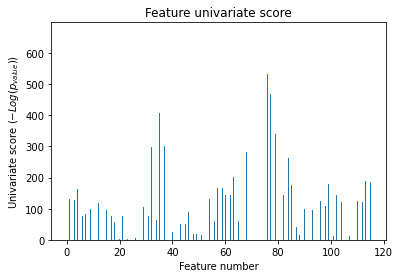

In [6]:
# target variable
target_var = 'FEDFUNDS'

from sklearn.feature_selection import SelectKBest, f_regression
X_train, y_train = data.loc[:, data.columns != target_var], data[target_var]

selector = SelectKBest(f_regression, k=15)
selector.fit(X_train, y_train)
scores = -np.log(selector.pvalues_)


X_indices = np.arange(X_train.shape[-1])
plt.figure(1)
plt.clf()
plt.bar(x = X_indices, height = scores, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.show()

In [7]:
score_df = pd.DataFrame([data.columns, scores]).T
score_df.columns = ['Feature', 'Score']
score_df = score_df.sort_values(by='Score', ascending=False)
score_df.head(20)

Feature       Score
73           TB6MS         inf
70        FEDFUNDS         inf
71           CP3Mx         inf
72           TB3MS         inf
74             GS1         inf
75             GS5  665.038375
76            GS10  531.223085
77             AAA  468.988664
36         DMANEMP  462.647261
35          MANEMP  408.282625
79       COMPAPFFx  341.041215
37        NDMANEMP   301.98306
32          USGOOD  299.360904
80        TB3SMFFM  298.745114
68   S&P div yield  281.161616
84         T10YFFM  261.445977
63          REALLN  202.746594
83          T5YFFM  197.642739
114    DTCOLNVHFNM  197.359388
113  CES3000000008  188.253891

## Working only with the varibales of interest

In [8]:
# get the relevant columns
endo = ['FEDFUNDS', 'INDPRO', 'TB3MS', 'PAYEMS', 'HOUST', 'DPCERA3M086SBEA', 'CPIAUCSL', 'M2REAL', 'BUSLOANS', 'S&P 500', 'S&P PE ratio']

data = data[endo]

<AxesSubplot:xlabel='sasdate'>

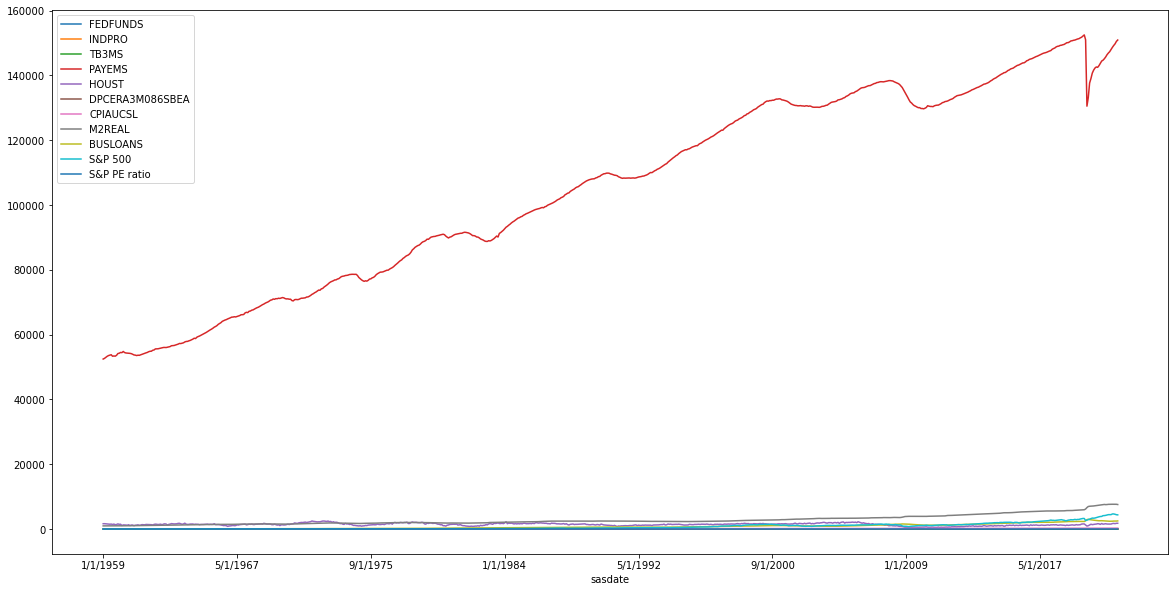

In [9]:
# check for stationarity
data.plot(figsize=(20,10))

Base on the plot above we can see the some of the series are not stationary. Therefore, we need to transform them into stationary series so that our model can remain consistent overtime.
   
Now not all series needs to be transfomed as some of the data are already pre-processed.  

FEDFUNDS


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


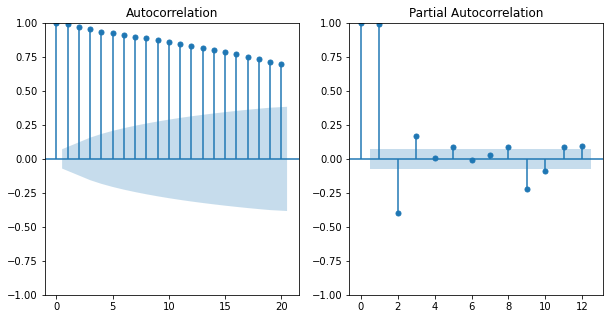

INDPRO


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


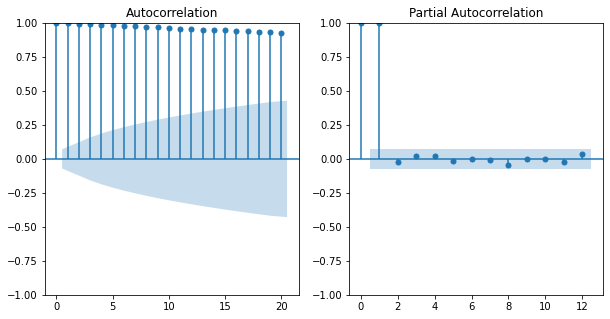

TB3MS


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


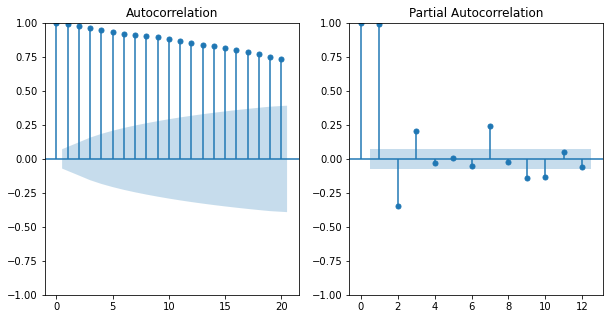

PAYEMS


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


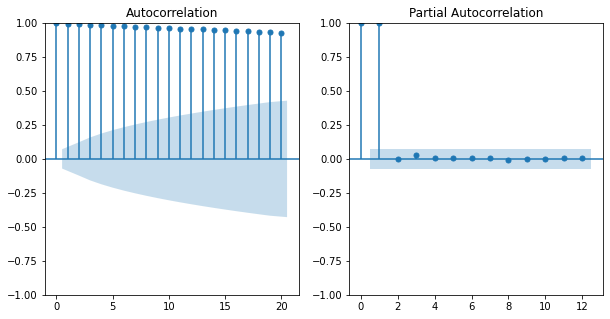

HOUST


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


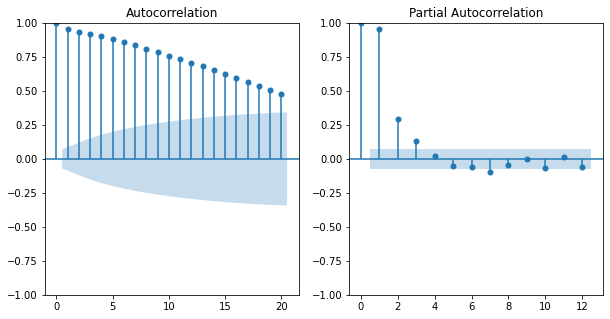

DPCERA3M086SBEA


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


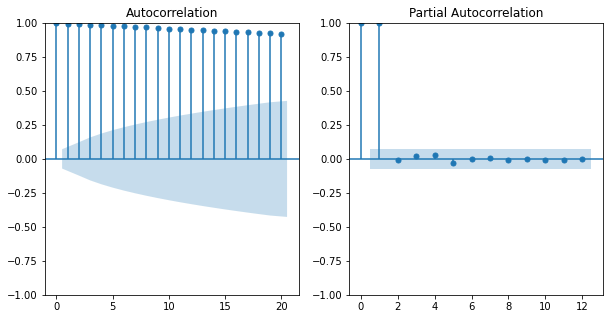

CPIAUCSL


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


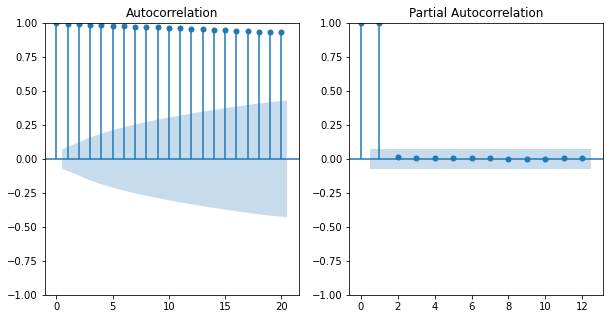

M2REAL


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


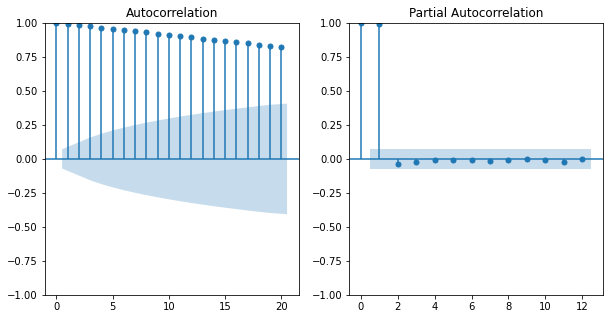

BUSLOANS


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


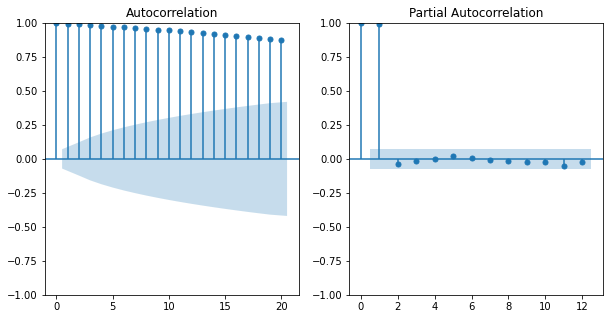

S&P 500


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


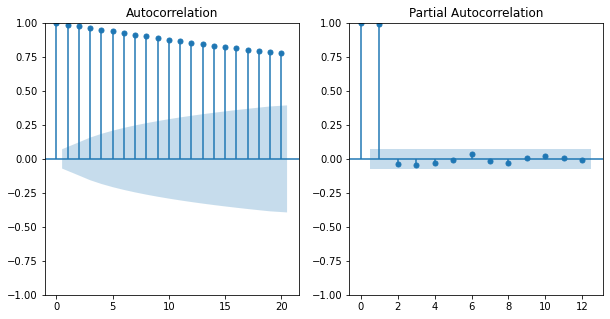

S&P PE ratio


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


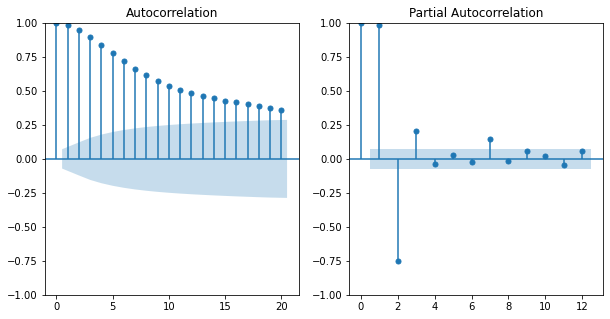

In [10]:
# acf & pacf
for column in data.columns:
    print(column)
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    sm.graphics.tsa.plot_acf(data[column], lags=20, ax=ax[0])
    sm.graphics.tsa.plot_pacf(data[column], lags=12, alpha=0.05, ax=ax[1])
    plt.show()


### Cointegration
we can model VAR with either stationary time series or cointegrated time series that are non-stationary. Testing cointegration is to ensure that the relationship between variables hold over time which is also the objective of using stationary time series.

In [11]:
# function to calculate the cointegration matrix
# organised pvalues into matrix
def coint_matrix(data):
    coint_matrix = pd.DataFrame(index=data.columns, columns=data.columns)
    for i in data.columns:
        for j in data.columns:
            if i != j:
                x = data[i]
                y = data[j]
                result = sm.tsa.stattools.coint(x, y)
                coint_matrix.loc[i,j] = result[1]
    # fill nan will 0
    coint_matrix = coint_matrix.fillna(0)
    return coint_matrix

<AxesSubplot:>

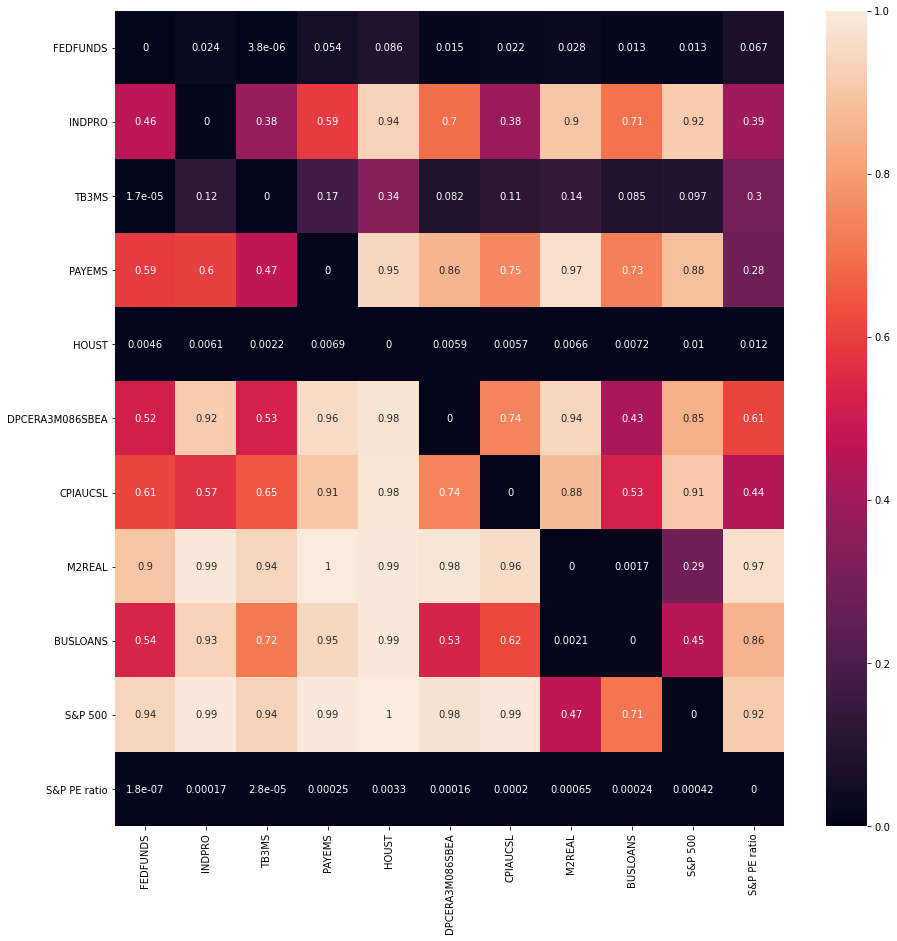

In [12]:
coint = coint_matrix(data)

# plot a heatmap of the cointegration matrix
plt.subplots(figsize=(15,15))
sns.heatmap(coint, annot=True)


statsmdoels uses augmented Engle-Granger test for cointegration.  
The Null hypothesis is that there is no cointegration, the alternative hypothesis is that there is cointegrating relationship. If the pvalue is small, below a critical size, then we can reject the hypothesis that there is no cointegrating relationship.  
System-wide cointegration does not imply pairwise cointegration, although pairwise cointegration does imply system-wide cointegration https://stats.stackexchange.com/questions/171066/cointegration-between-more-than-two-variables  
from the above cointegration p-value heatmap, we see that new private housing and PE ratio are not cointegrated with the other series. As a result we are dropping these two series from our model.  
we are retaining Fed fund rate as it is the key pathway to manage monetary policy.

In [13]:
# drop the columns with pvalue > 0.05
data = data.drop(['HOUST', 'S&P PE ratio'], axis=1)
data.head()

FEDFUNDS   INDPRO  TB3MS   PAYEMS  DPCERA3M086SBEA  CPIAUCSL  \
sasdate                                                                  
1/1/1959      2.48  22.0733   2.82  52478.0           17.272     29.01   
2/1/1959      2.43  22.5056   2.70  52688.0           17.452     29.00   
3/1/1959      2.80  22.8298   2.80  53014.0           17.617     28.97   
4/1/1959      2.96  23.3161   2.95  53321.0           17.553     28.98   
5/1/1959      2.90  23.6673   2.84  53550.0           17.765     29.04   

          M2REAL  BUSLOANS  S&P 500  
sasdate                              
1/1/1959   987.9   35.2130    55.62  
2/1/1959   992.1   35.2201    54.77  
3/1/1959   998.3   35.1304    56.16  
4/1/1959  1001.0   35.5581    57.10  
5/1/1959  1006.2   36.3064    57.96

In [14]:
# stationarity test
output = []
for column in data.columns:
    pval = tsa.adfuller(data[column], maxlag=12, regression='c', autolag='AIC')[1]
    output.append(pval)
output = pd.DataFrame(output).T
output.columns = data.columns
odd = output.columns[output.mean() >= 0.05]
output[odd].mean()

FEDFUNDS           0.310043
INDPRO             0.824780
TB3MS              0.406172
PAYEMS             0.794891
DPCERA3M086SBEA    0.999035
CPIAUCSL           0.999018
M2REAL             0.998983
BUSLOANS           0.998494
S&P 500            1.000000
dtype: float64

<AxesSubplot:xlabel='sasdate'>

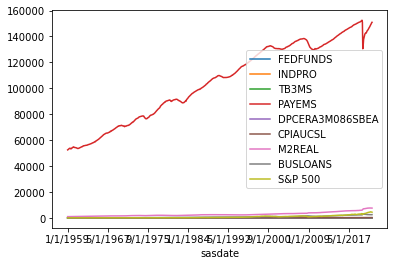

In [15]:
data.plot()

# VAR model 


As our data set is extremely large, we will first select features before using VAR model to perform estimation. (VAR model is not suitable for large data set, an alternative would be to use baysian VAR) 

In [16]:
VAR_model = VAR(data) 
VAR_model.select_order(24)
results = VAR_model.fit(maxlags=24, ic='aic')
results.summary()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 25, May, 2022
Time:                     20:25:53
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    27.4062
Nobs:                     738.000    HQIC:                   20.8521
Log likelihood:          -13891.1    FPE:                2.06899e+07
AIC:                      16.7385    Det(Omega_mle):     2.63229e+06
--------------------------------------------------------------------
Results for equation FEDFUNDS
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.130241         0.337934           -0.385           0.700
L1.FEDFUNDS                 0.848232         0.058968           14.385           0.000
L1.INDPRO                   0.138

In [17]:
lag_order = results.k_ar
lag_order

21

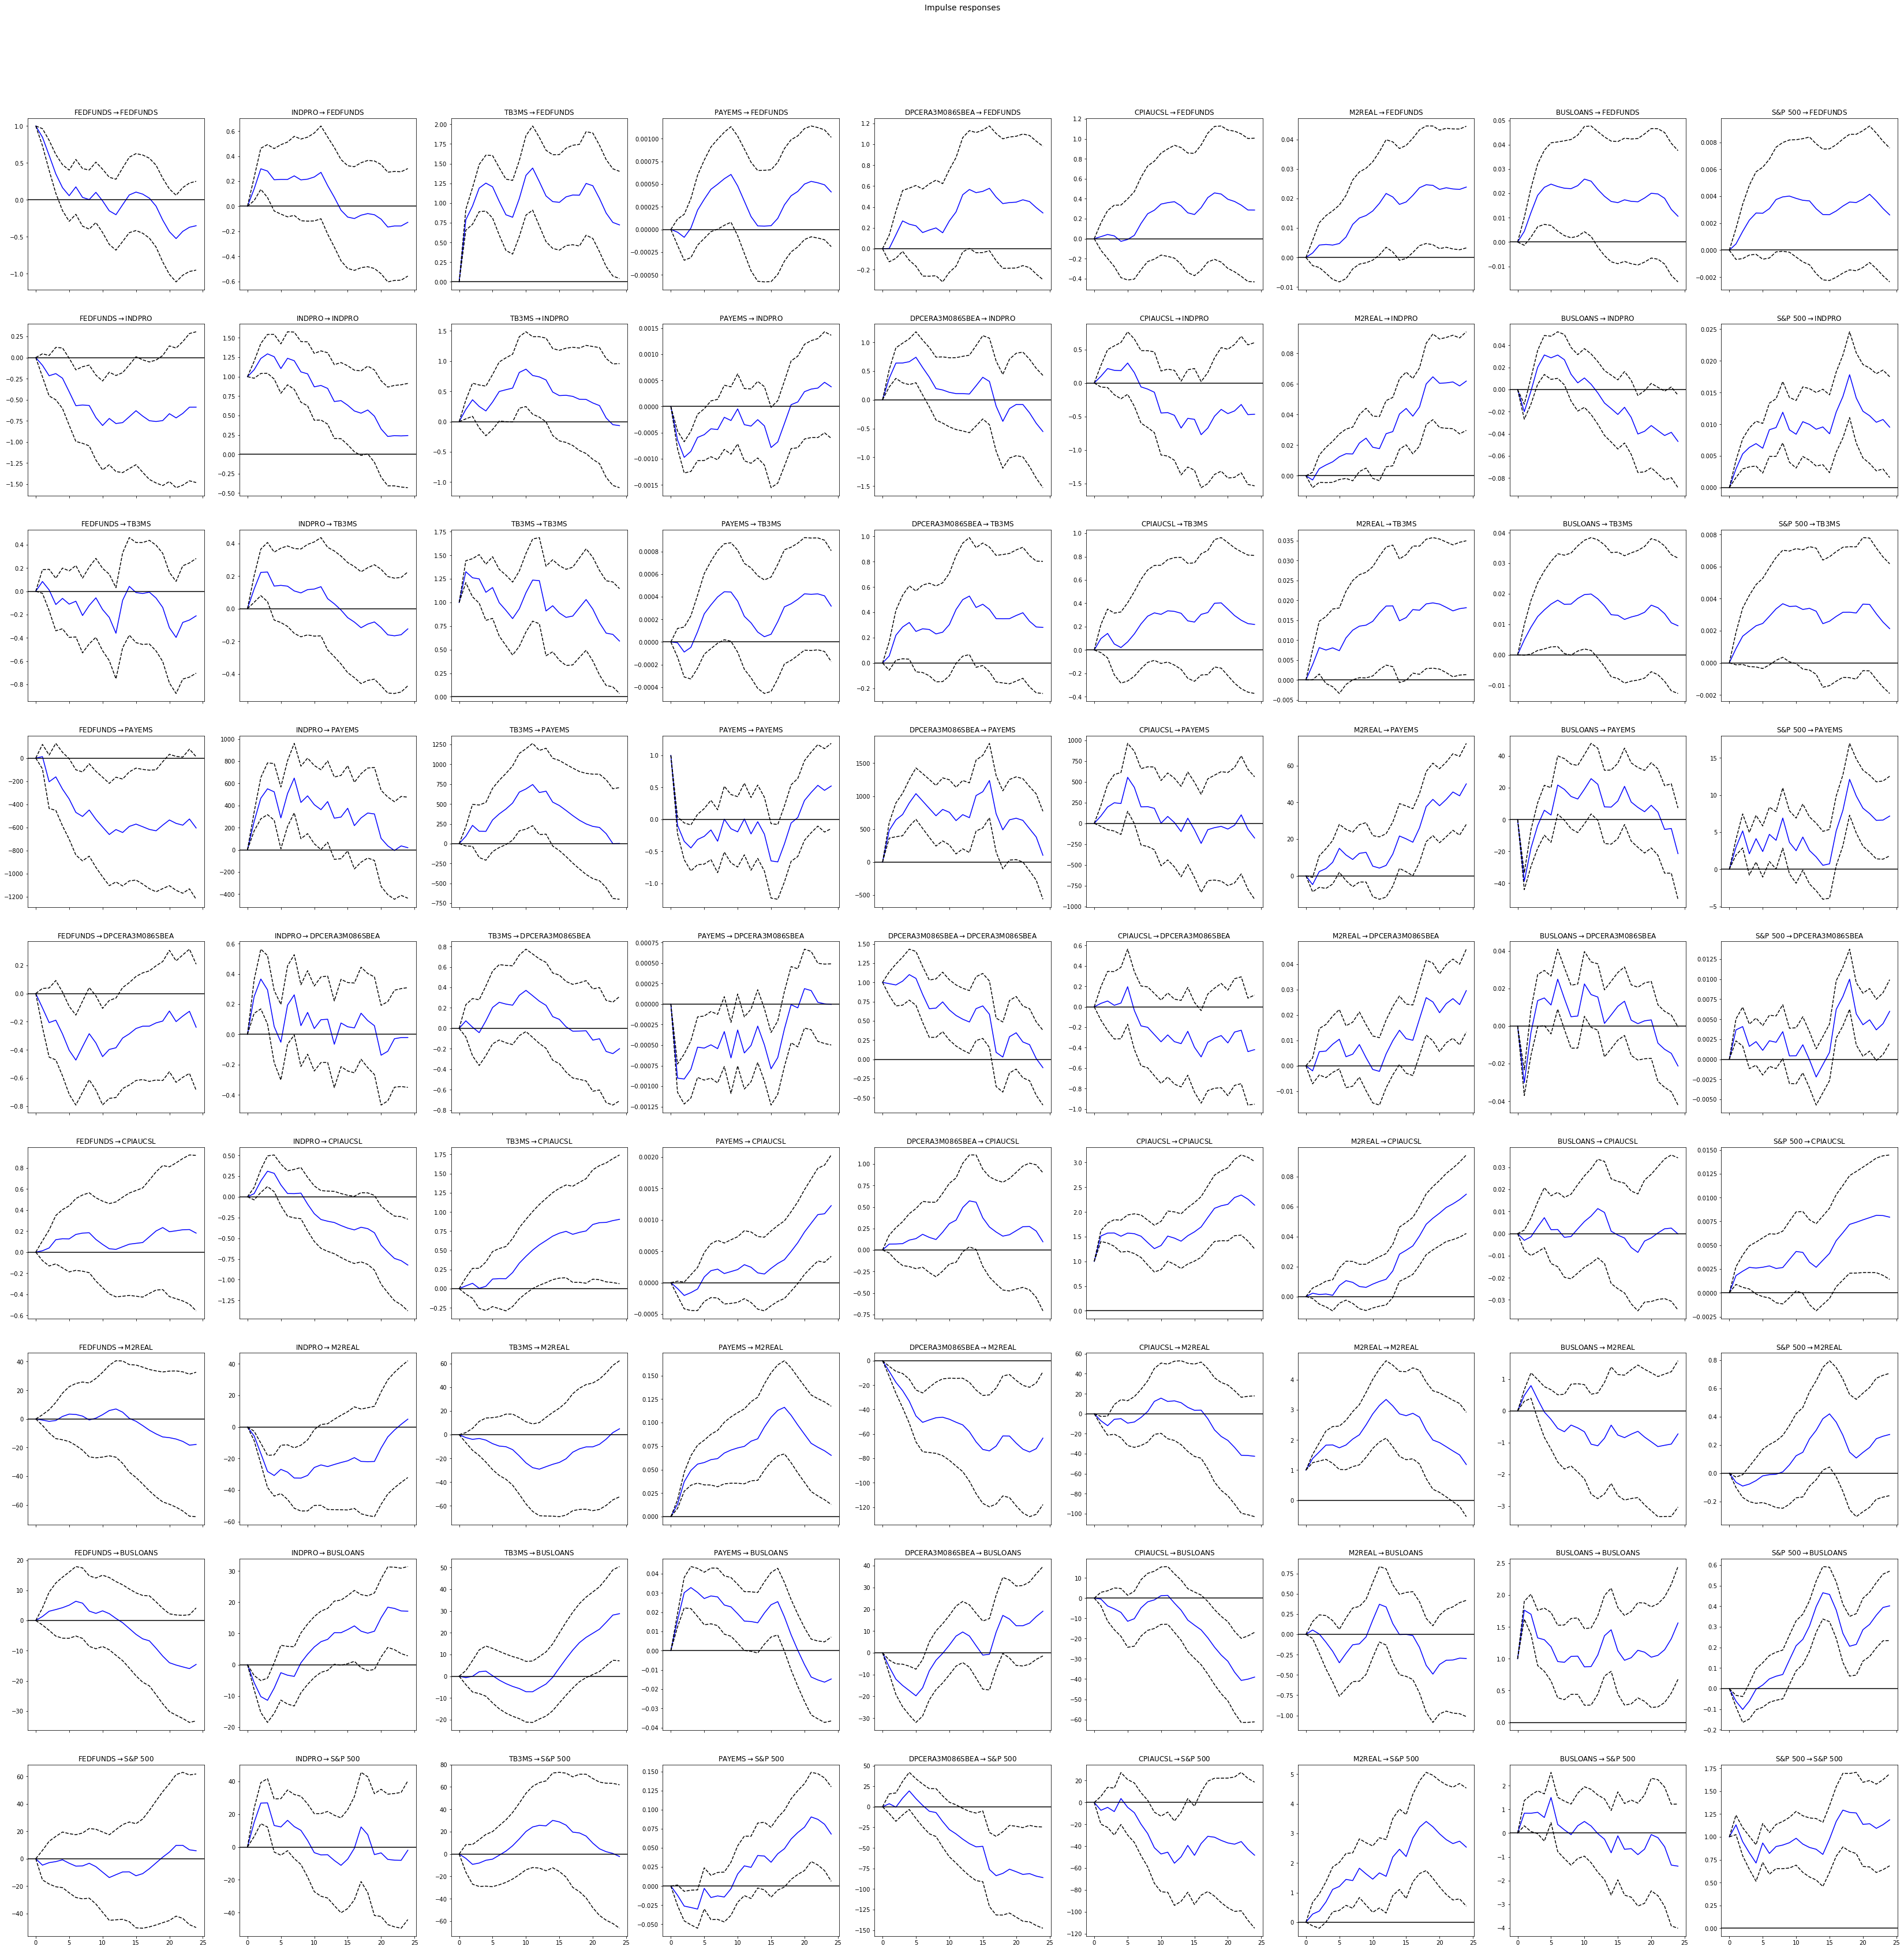

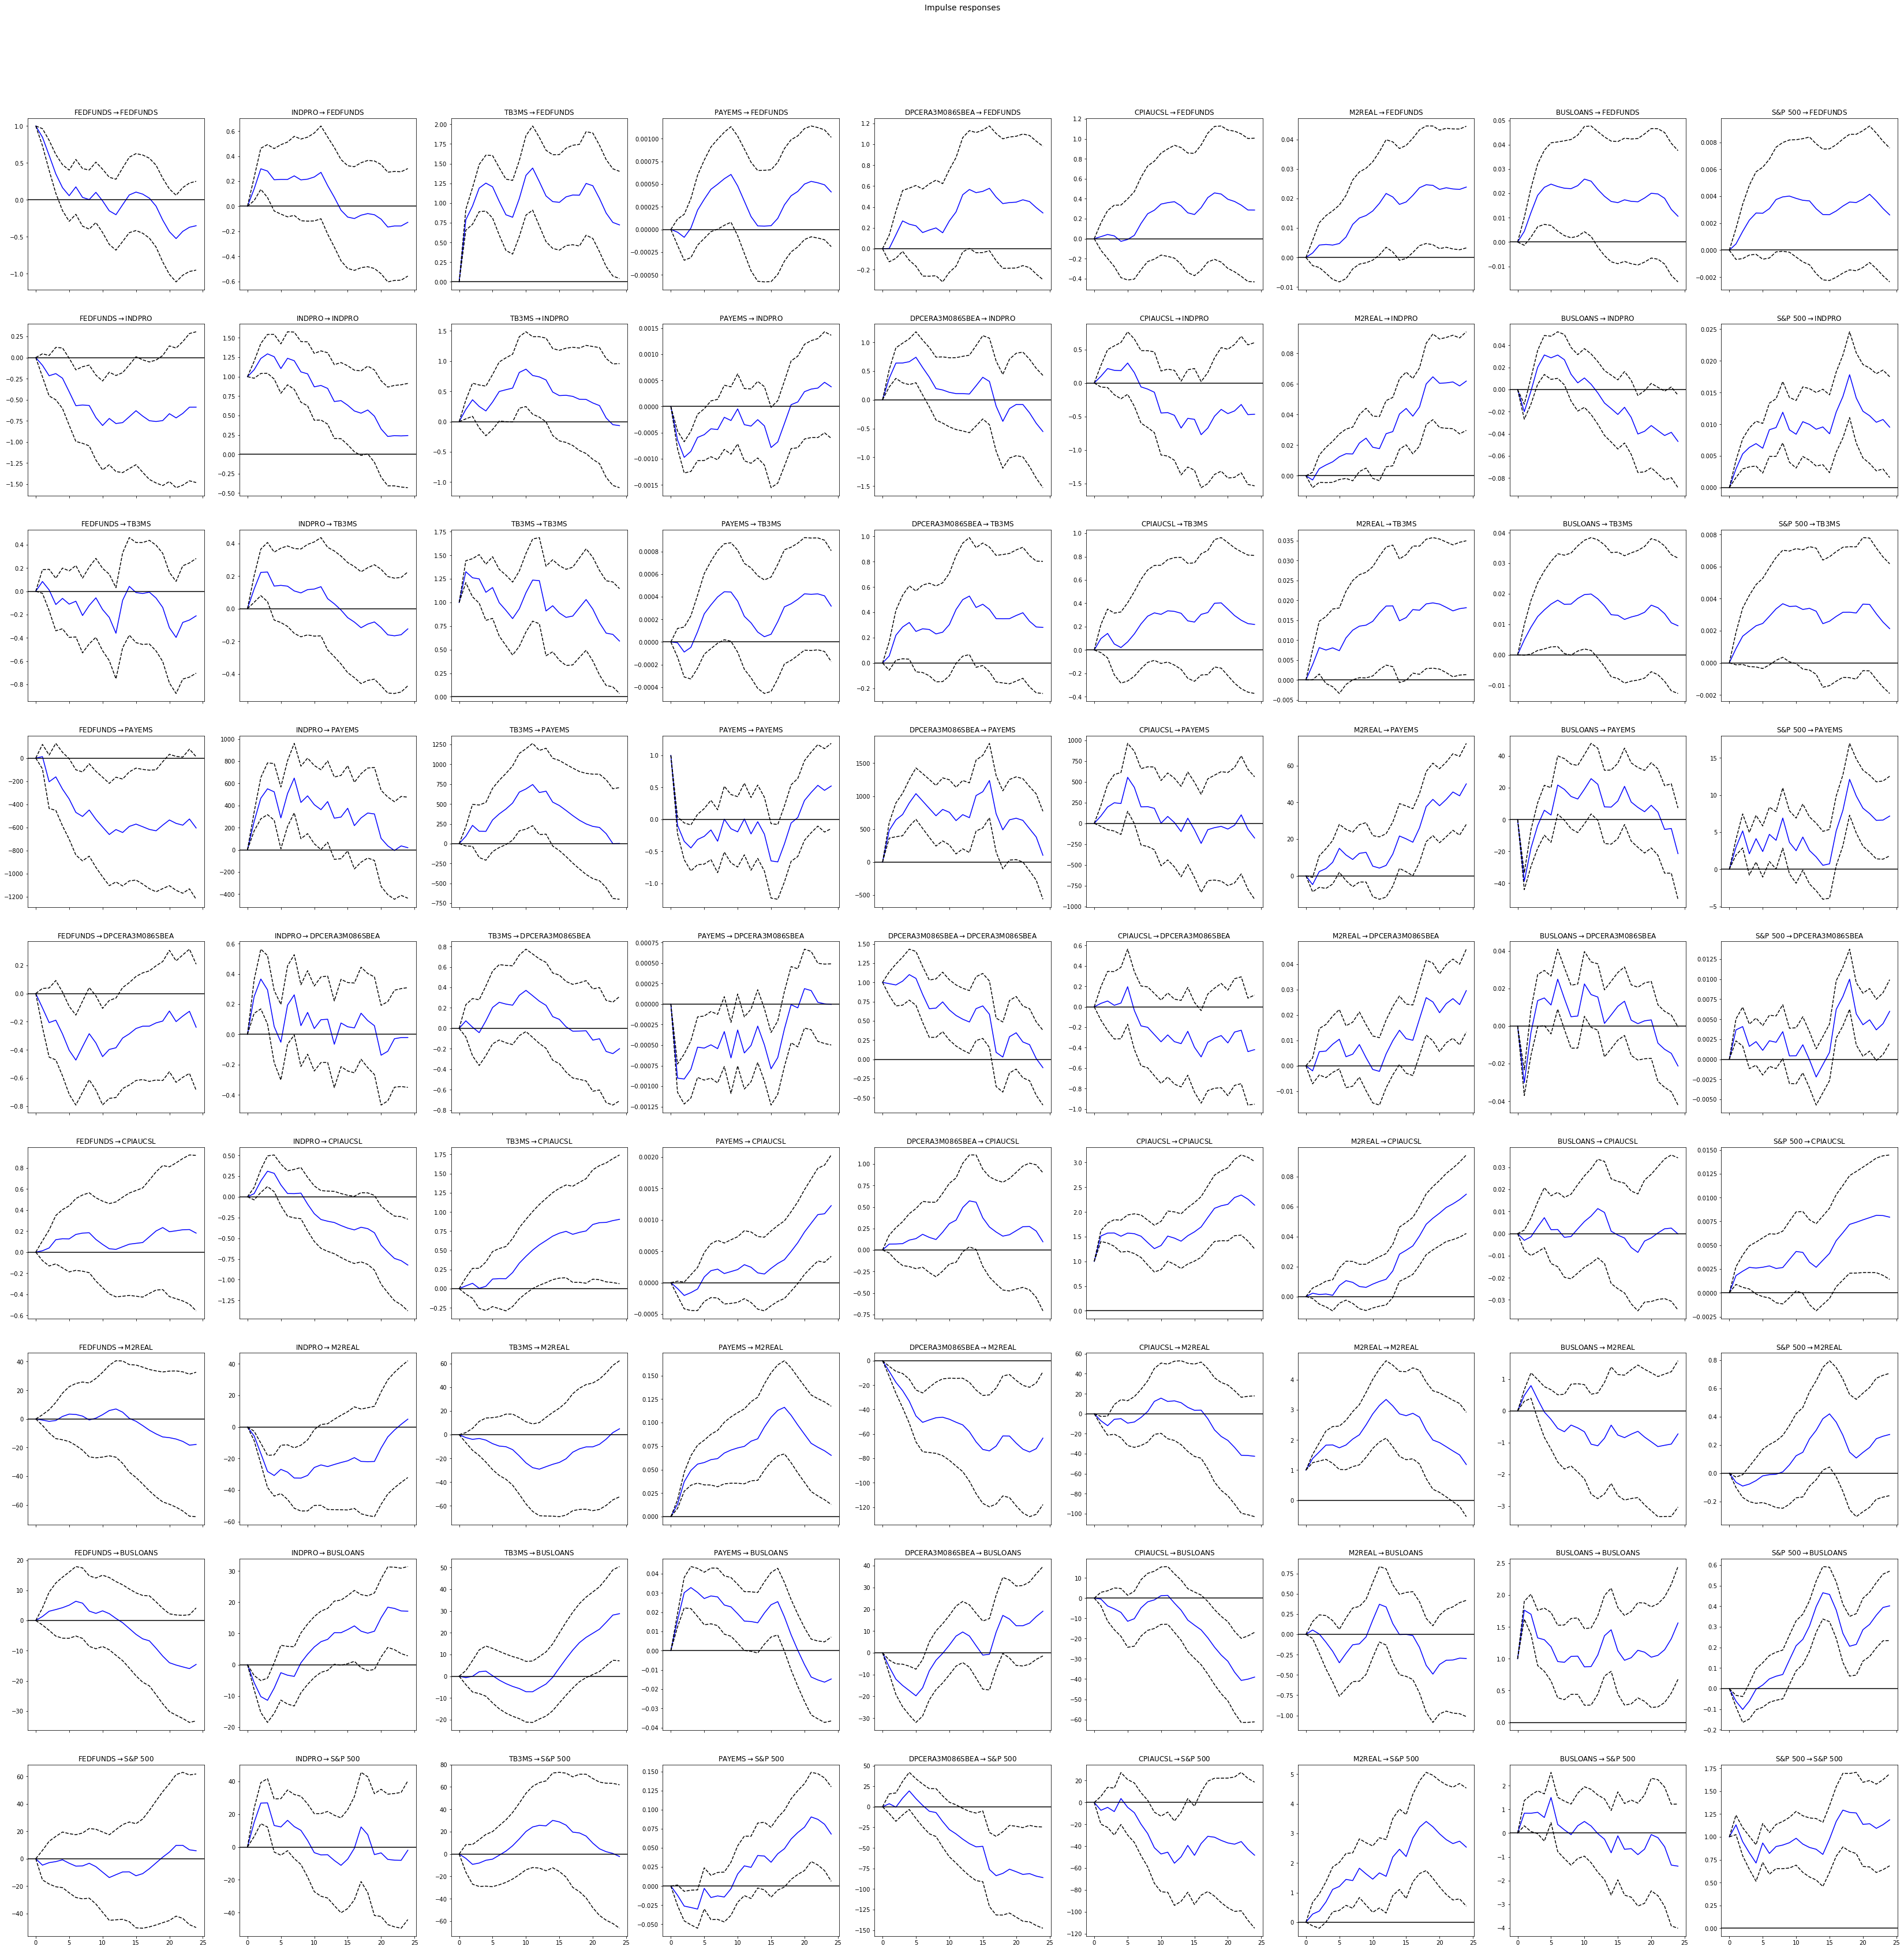

In [18]:
irf = results.irf(24)
irf.plot(orth=False, figsize=(50, 50))

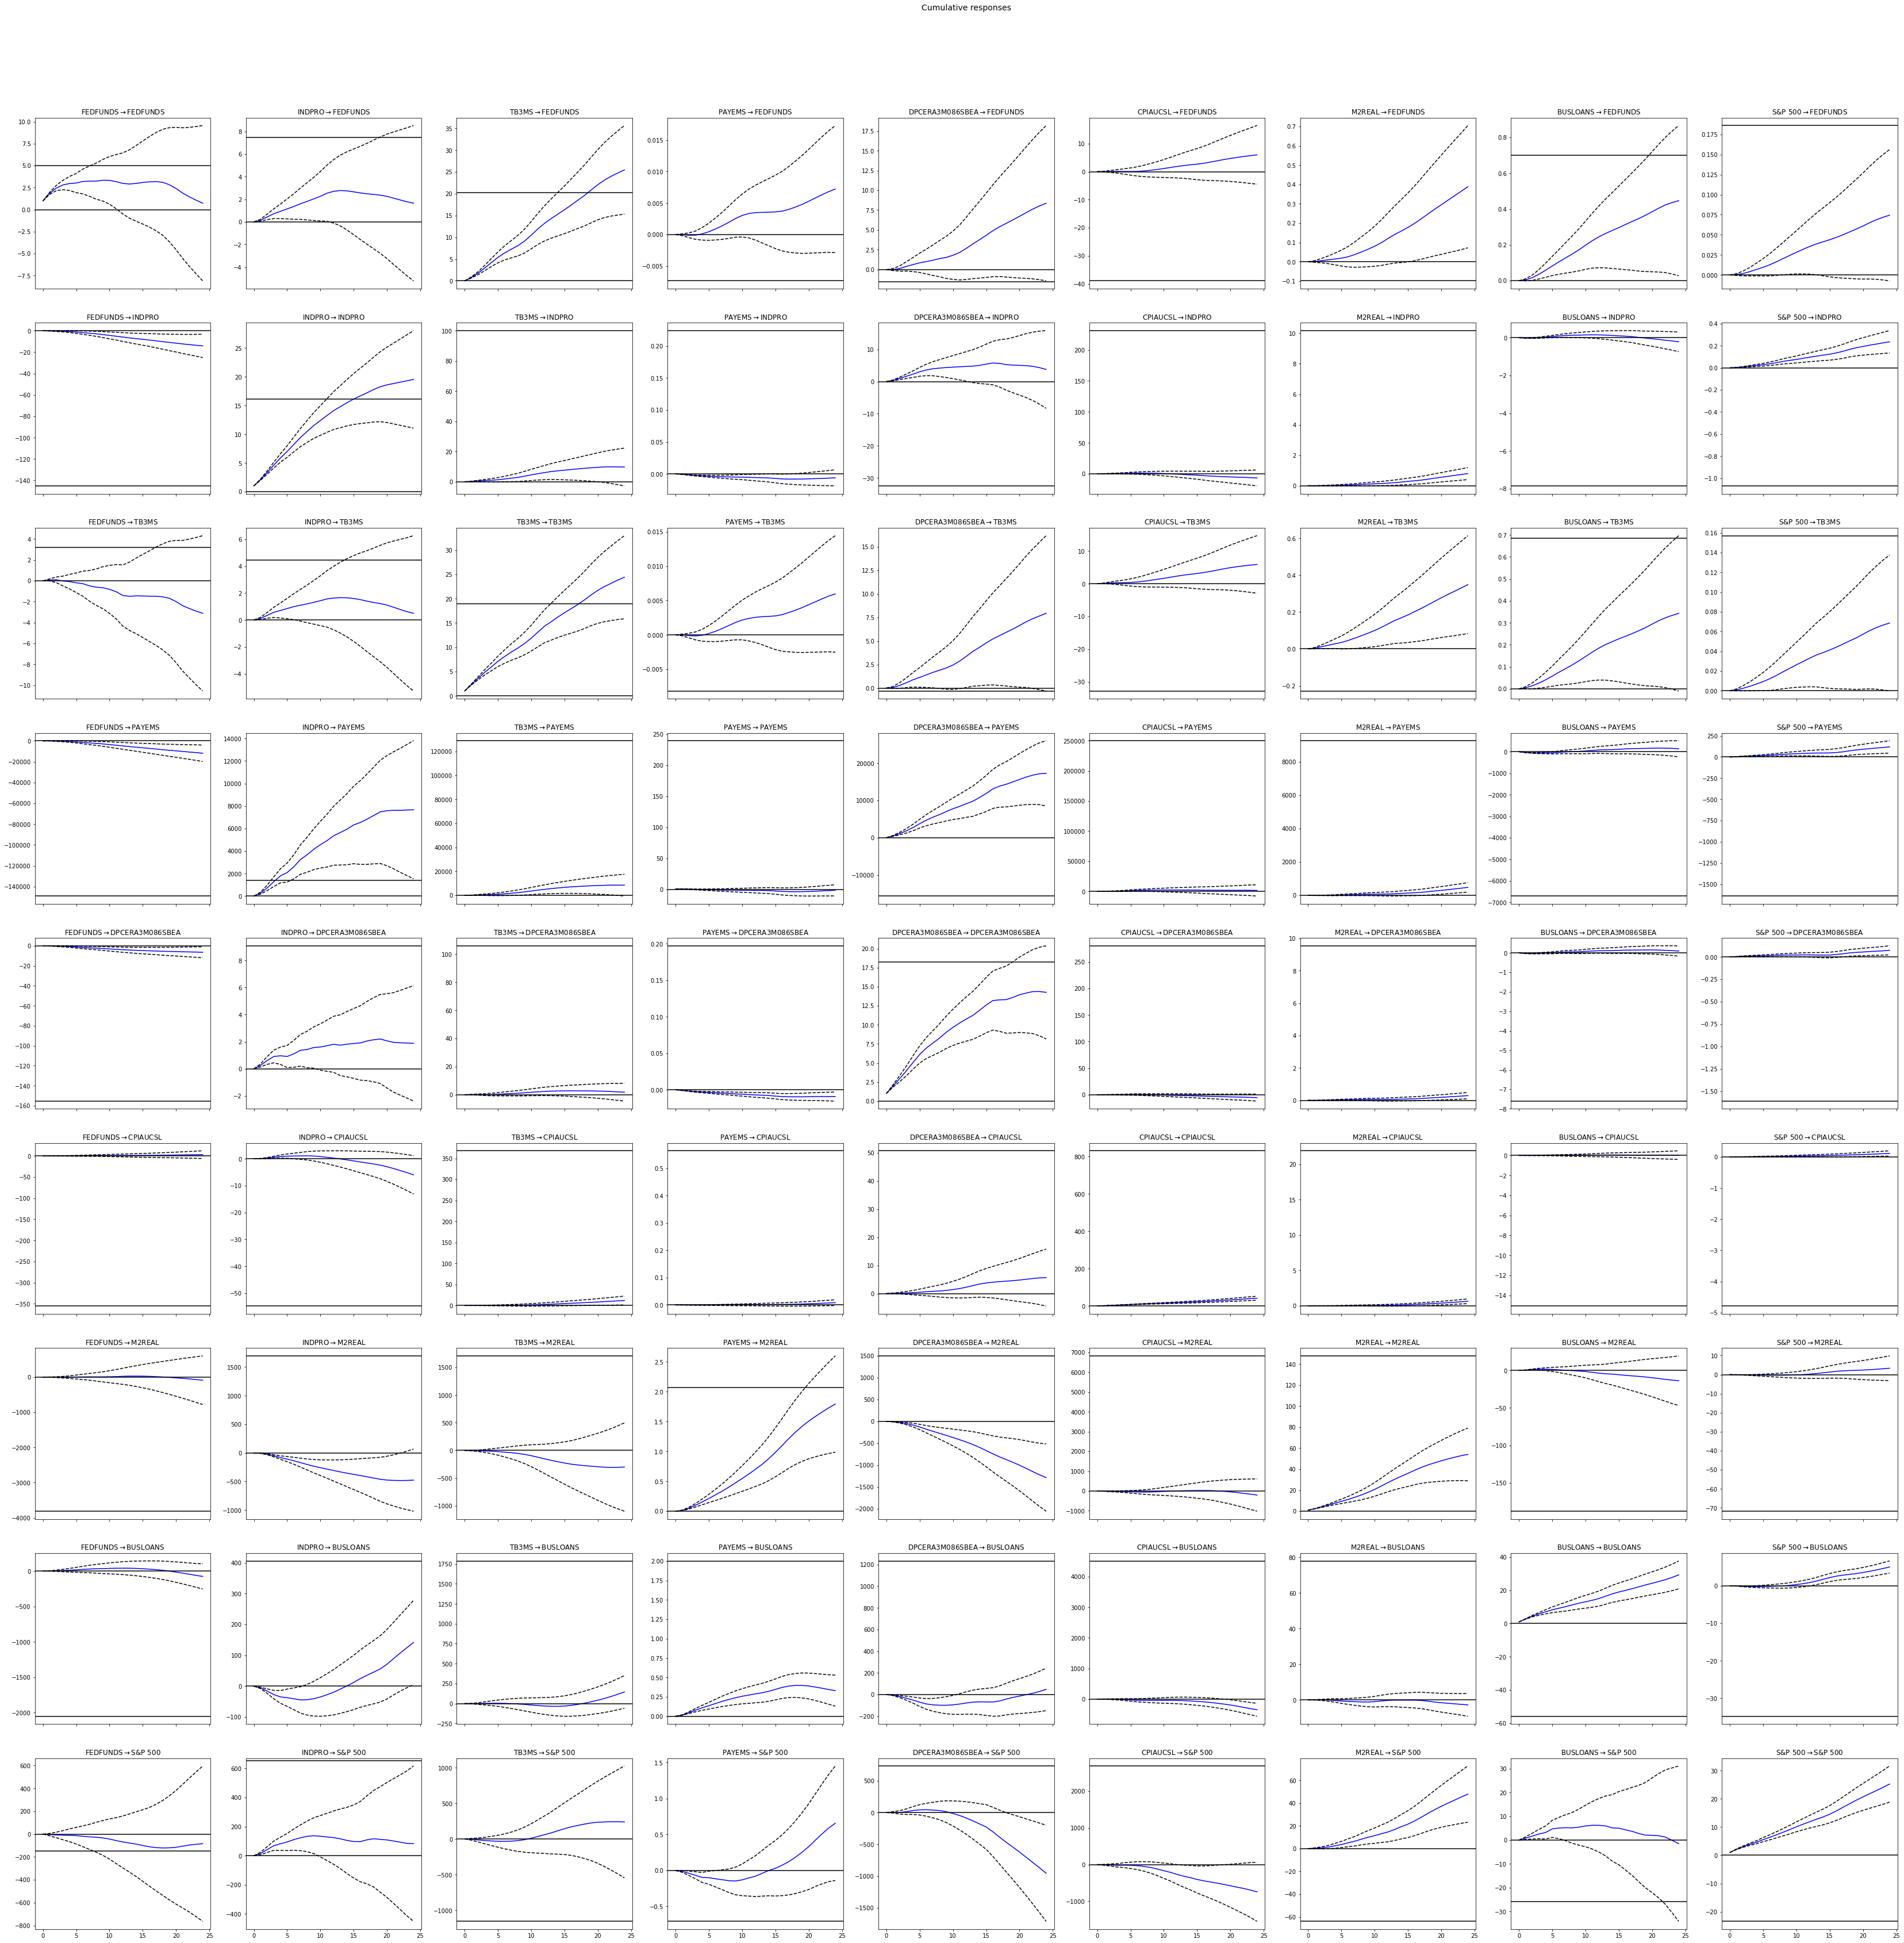

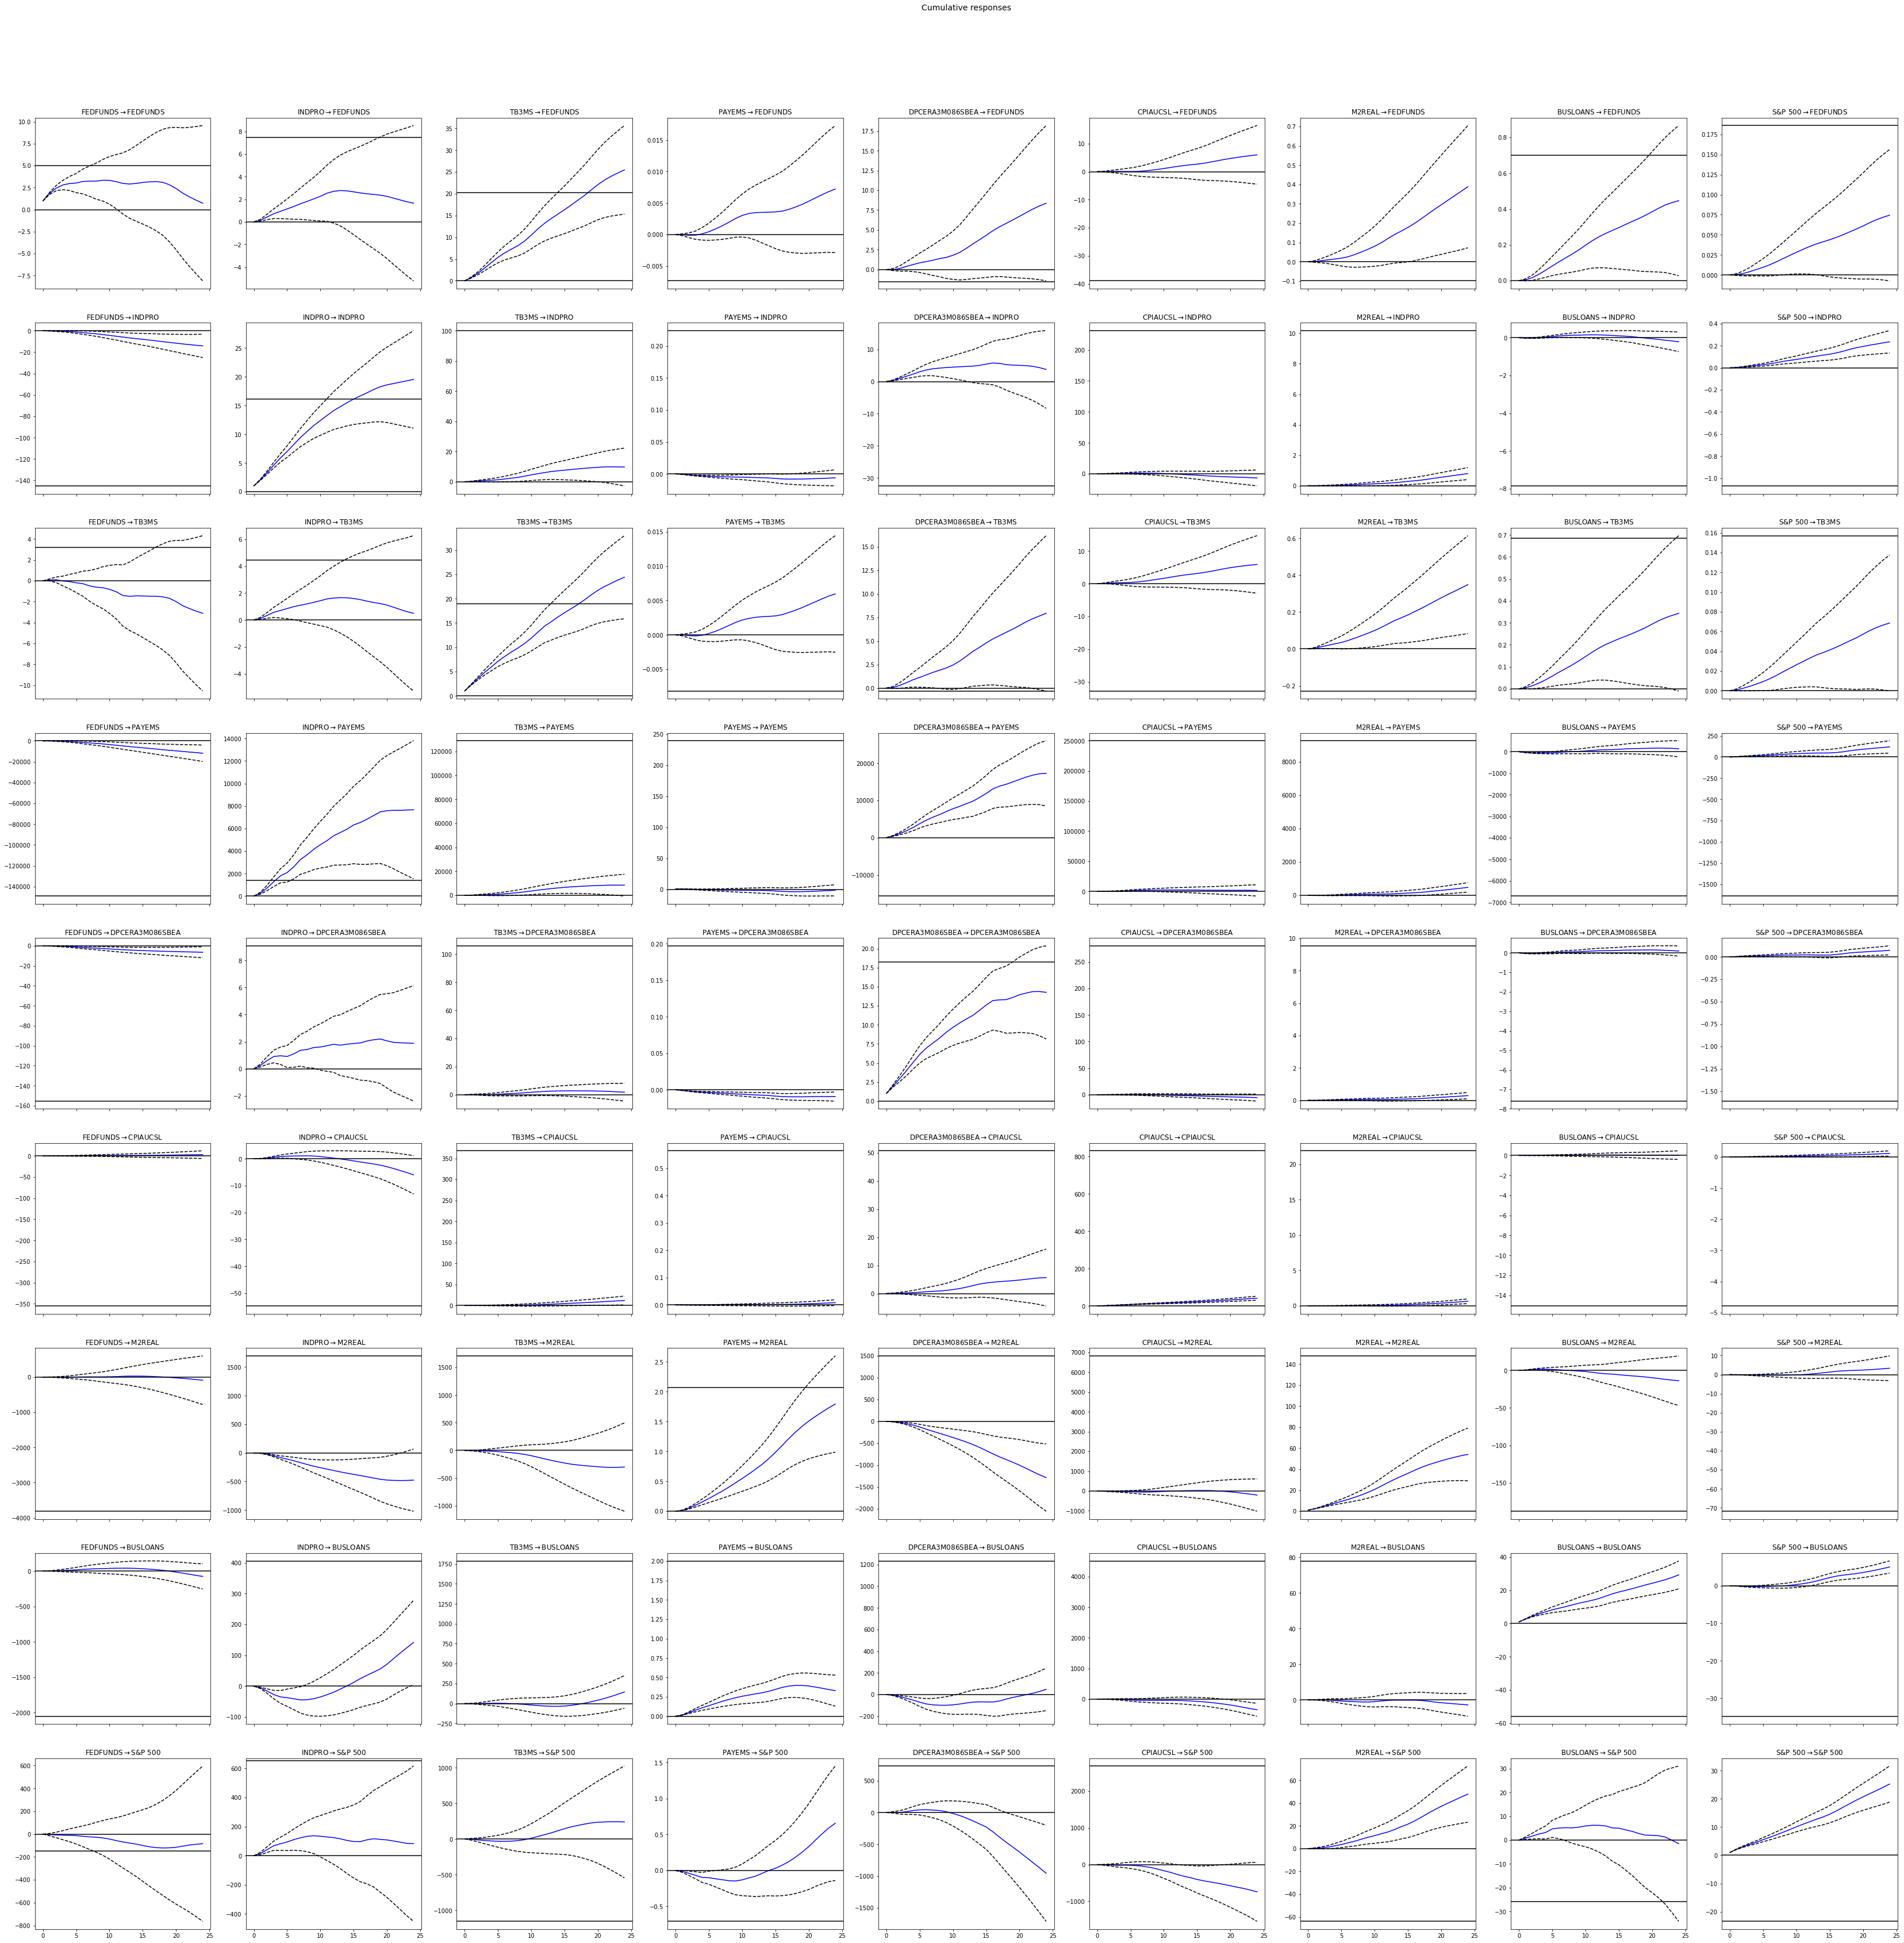

In [20]:
irf.plot_cum_effects(orth=False, figsize=(50, 50))

In [19]:
# forecast error varince decomposition
fevd = results.fevd(lag_order)

fevd.summary()

FEVD for FEDFUNDS
      FEDFUNDS    INDPRO     TB3MS    PAYEMS  DPCERA3M086SBEA  CPIAUCSL    M2REAL  BUSLOANS   S&P 500
0     1.000000  0.000000  0.000000  0.000000         0.000000  0.000000  0.000000  0.000000  0.000000
1     0.909613  0.006615  0.079141  0.001706         0.000838  0.000012  0.000696  0.001016  0.000361
2     0.842492  0.021506  0.119517  0.004967         0.000671  0.000151  0.003464  0.005064  0.002169
3     0.775524  0.034219  0.162949  0.004250         0.000577  0.000276  0.005613  0.011495  0.005097
4     0.723692  0.041072  0.197546  0.003448         0.000489  0.000760  0.007048  0.017565  0.008381
5     0.682352  0.049213  0.220374  0.003679         0.000675  0.001039  0.008757  0.023159  0.010751
6     0.659838  0.055495  0.226265  0.004524         0.001509  0.001259  0.011121  0.026496  0.013492
7     0.635028  0.064484  0.228673  0.005737         0.002098  0.001245  0.015874  0.028954  0.017907
8     0.612149  0.071623  0.230040  0.007639         0.002565  0